In [71]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import multivariate_normal as mvn

In [72]:
# problem 2

In [104]:
class EM_GMM:
    
    def __init__(self, X, k = 3):
        # read file
        self.X = X
        self.k = k
        
        # number of data (m) and feature (n)
        self.m, self.n = self.X.shape
        
        # initial
        self.initial_condition()
    
    def initial_condition(self):
        # extract sample mean and cov
        mean = np.mean(self.X, axis = 0)
        cov = np.cov(self.X, rowvar = False)
                
        # random generate mean, using multivariate normal with sample mean and cov
        self.mean = np.random.multivariate_normal(mean, cov, self.k)
        assert self.mean.shape == (self.k, self.n)
        
        # use overall variacne as initial cov
        self.cov = {}
        for i in range(self.k):
            self.cov[i] = cov # dimension n * n
            
        # Initialize the mixing weights to be uniform.
        self.pi = np.ones(self.k)/self.k # dimension n * 1
        
    def E_M(self, iter_ = 30):
        self.obj = np.ndarray(iter_)
        # initiate phi matrix with dimension m * k
        self.phi = np.zeros((self.m, self.k))
        
        # iterate E & M steps
        for i in range(iter_):
            self.E_step()
            self.M_step()
            self.obj[i] = self.cal_obj()

    def E_step(self):
        pdf = np.zeros((self.m, self.k))
        for idx in range(self.k):
            # gaussian part
            pdf[:,idx] = self.gaussian(self.X, idx)
            # multiply pi
            pdf[:,idx] *= self.pi[idx]
        # normalize each row
        self.phi = pdf / np.sum(pdf, axis = 1).reshape(-1,1)
        

    def M_step(self):
        # pre calculate Nk
        Nk = np.sum(self.phi, axis = 0)
        
        # update pi
        self.pi = np.mean(self.phi, axis = 0)

        # update mean
        for idx in range(self.k):
            # update mean by class
            self.mean[idx] = self.phi[:, idx].dot(self.X) / Nk[idx]
            
            # update cov
            cov_ = np.zeros((self.n, self.n))
            mean_diff = self.X - self.mean[idx]
            for i in range(self.m):
                cov_ += self.phi[i,idx] * np.outer(mean_diff[i,:],mean_diff[i,:])
            self.cov[idx] = cov_ / Nk[idx]

    def gaussian(self, X, k):
        # add 1e-10 to diagonal preventing singular matrix
        modify_cov = self.cov[k] + np.eye(self.n) * 1e-10
        # use mvn to get pdf
        pdf = mvn.pdf(X, mean = self.mean[k], cov = modify_cov)
        return pdf

    def cal_obj(self):
        pdf = np.zeros((self.m, self.k))
        for idx in range(self.k):
            # gaussian part
            pdf[:,idx] = self.gaussian(self.X, idx)
            # multiply pi
            pdf[:,idx] *= self.pi[idx]
        return np.sum(np.log(np.sum(pdf, axis = 1)))

In [105]:
# import data
X = pd.read_csv('Prob2_Xtrain.csv', header = None).values
y = pd.read_csv('Prob2_ytrain.csv', header = None).values
X_t = pd.read_csv('Prob2_Xtest.csv', header = None).values
y_t = pd.read_csv('Prob2_ytest.csv', header = None).values

In [106]:
# initiate dict for storing
class1_prior = {}
class0_prior = {}

# initiate with 2 different class
for i in range(10):
    class1_prior[i] = EM_GMM(X[(y==1).reshape(-1,),:])
    class0_prior[i] = EM_GMM(X[(y==0).reshape(-1,),:])

# run EM for both classes 10 times
for i in range(10):
    print('run ' + str(i+1))
    class1_prior[i].E_M()
    class0_prior[i].E_M()

run 1
run 2
run 3
run 4
run 5
run 6
run 7
run 8
run 9
run 10


In [107]:
# extract objective function value from 5 to 30 iter
obj_1 = np.ndarray((10,26))
obj_0 = np.ndarray((10,26))

for i in range(10):
    obj_1[i,:] = class1_prior[i].obj[4:]
    obj_0[i,:] = class0_prior[i].obj[4:]

In [109]:
def make_plot(obj, title):
    plt.figure(figsize=(8, 6))
    for i in range(10):
        sns.lineplot(x= range(5,31), 
                 y = obj[i,:], 
                 label = 'run ' + str(i+1))
    _ = plt.xlabel('Iteration')
    _ = plt.ylabel('Objective function values')
    _ = plt.title(title)
    _ = plt.legend(ncol=2)

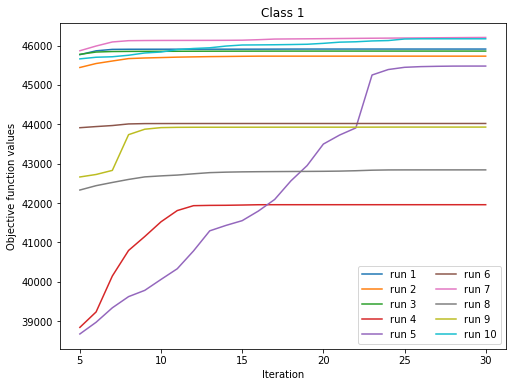

In [110]:
make_plot(obj_1, 'Class 1')

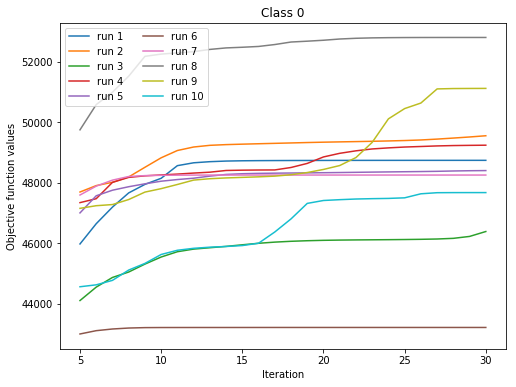

In [112]:
make_plot(obj_0, 'Class 0')

In [116]:
# choose best fit based on last objective function value
class1_ind = np.argmax(obj_1[:,-1])
class0_ind = np.argmax(obj_0[:,-1])

In [139]:
# caculate mle
mle = np.zeros((X_t.shape[0],2))
for i in range(3):
    # class 1
    mle[:,1] += (class1_prior[class1_ind].pi[i] * 
        mvn.pdf(X_t, class1_prior[class1_ind].mean[i], class1_prior[class1_ind].cov[i]))
    # class 0
    mle[:,0] += (class0_prior[class0_ind].pi[i] * 
        mvn.pdf(X_t, class0_prior[class0_ind].mean[i], class0_prior[class0_ind].cov[i]))
# predict based on the mle values
Y_pred = pd.Series(np.argmax(mle,axis = 1), name='Predicted')

In [140]:
# confusion matrix
Y_true = pd.Series(y_t.reshape(-1), name='Actual')
pd.crosstab(Y_pred, Y_true)

Actual,0,1
Predicted,,
0,208,10
1,70,172


In [145]:
print('accuracy = ' + str(np.sum(Y_pred == Y_true)/Y_pred.shape[0]*100)+' %')

accuracy = 82.6086956521739 %


In [153]:
# repeat for 1, 2, 3, 4 gaussian
# initiate dict for storing
K_class1_prior = {}
k_class0_prior = {}

# initiate with 2 different class
for k in range(4):
    K_class1_prior[k] = EM_GMM(X[(y==1).reshape(-1,),:], k+1)
    k_class0_prior[k] = EM_GMM(X[(y==0).reshape(-1,),:], k+1)

# run EM
for i in range(4):
    print(str(i+1) + ' Gaussian')
    K_class1_prior[i].E_M()
    k_class0_prior[i].E_M()

1 Gaussian
2 Gaussian
3 Gaussian
4 Gaussian


In [157]:
def precition(prior1, prior0, X_t, Y_true):
    mle = np.zeros((X_t.shape[0],2))
    for i in range(prior1.k):
        # class 1
        mle[:,1] += (prior1.pi[i] * 
            mvn.pdf(X_t, prior1.mean[i], prior1.cov[i]))
        # class 0
        mle[:,0] += (prior0.pi[i] * 
            mvn.pdf(X_t, prior0.mean[i], prior0.cov[i]))

        # predict based on the mle values
    Y_pred = pd.Series(np.argmax(mle,axis = 1), name='Predicted')
    print(str(prior1.k) + ' Gaussian')
    print(pd.crosstab(Y_pred, Y_true))
    print('accuracy = ' + str(np.sum(Y_pred == Y_true)/Y_pred.shape[0]*100)+' %')
    print()

In [158]:
for i in range(4):
    precition(K_class1_prior[i], k_class0_prior[i], X_t, Y_true)

1 Gaussian
Actual       0    1
Predicted          
0          180    6
1           98  176
accuracy = 77.39130434782608 %

2 Gaussian
Actual       0    1
Predicted          
0          191    9
1           87  173
accuracy = 79.13043478260869 %

3 Gaussian
Actual       0    1
Predicted          
0          202    7
1           76  175
accuracy = 81.95652173913044 %

4 Gaussian
Actual       0    1
Predicted          
0          192    5
1           86  177
accuracy = 80.21739130434783 %

